# Lokaverkefni TÖL403G 2025

## Höfundar
Sigurður Ari Stefánsson

Svava Þóra Árnadóttir

## imports

In [4]:
import pandas as pd
import heapq
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import time
from math import sqrt


# Liður 2.3.1 (*) 

### Þáttun

Lesið inn netið úr skránum sem eru gefnar, nodes.tsv og edges.tsv. Í skránni nodes.tsv
eru hnútar með auðkenni (id), hnit (x, y) og hvort þeir séu á aðalvegi (primary). Í skránni
edges.tsv eru leggi frá hnúti u til hnúts v með lengd length, mæld í metrum, og nafn
(name).

In [5]:
# Lesa og hreinsa gögn 
nodes_df = pd.read_csv('nodes.tsv', sep='\t', header=0, names=['id', 'x', 'y', 'primary'])
edges_df = pd.read_csv('edges.tsv', sep='\t', header=0, names=['u', 'v', 'length', 'name'])

nodes_df = nodes_df[nodes_df['id'] != 'osmid']
edges_df = edges_df[edges_df['u'] != 'u']

nodes_df['id'] = nodes_df['id'].astype(int)
nodes_df['x'] = nodes_df['x'].astype(float)
nodes_df['y'] = nodes_df['y'].astype(float)
nodes_df['primary'] = nodes_df['primary'].astype(bool)

edges_df['u'] = edges_df['u'].astype(int)
edges_df['v'] = edges_df['v'].astype(int)
edges_df['length'] = edges_df['length'].astype(float)


# Liður 2.3.2 (**)

### Leit

Ef við setjum hleðslustöðvar á hnúta v1, . . . , vk þá er hægt að nota reikniritið dijkstra til að
finna stystu fjarlægð frá hnverjum hnúti u í hleðslustöð vi. Útfærið reikniritið sem tekur
inn lista af lokahnútum og reiknar fjarlægðir frá öllum hnútum í netinu. Athugið að netið
er stefnt net.

In [6]:
# Multi-source Dijkstra: reiknar stystu leið í einhverja hleðslustöð
def dijkstra_to_charging(graph, charging_nodes):
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    reversed_graph = defaultdict(list)

    # Snúa netinu við til þess að reikna vegalengd frá hnút að stöð
    for u in graph:
        for v, weight in graph[u]:
            reversed_graph[v].append((u, weight))

    # Upphafsstilla fjarlægðir á hleðslustöðvum sem 0 og setja á heap. 
    for station in charging_nodes:
        dist[station] = 0
        heapq.heappush(heap, (0, station))

    visited_count = 0
        
    # Leit
    while heap:
        current_dist, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        visited_count += 1

        for v, weight in reversed_graph[u]:
            if dist[v] > current_dist + weight:
                dist[v] = current_dist + weight
                heapq.heappush(heap, (dist[v], v))

    #print(f"Dijkstra visited {visited_count} nodes.")
    return dist


In [7]:
# breytir punkt í google maps link
gmaps_urls = {}
for _, row in nodes_df.iterrows():
    gmaps_urls[row['id']] = f"https://www.google.com/maps?q={row['y']},{row['x']}"

print(gmaps_urls[12885922])

https://www.google.com/maps?q=64.0319775,-22.0878904


# Liður 2.3.3 (*)

### Framsetning

Setjið fimm hleðslustöðvar í netið og sýnið stystu leið fyrir fimm punkta og teiknið upp á
kort. Tékkið ykkur af með því að bera saman leiðina sem er fundin og fjarlægðina miðað
við kortavefi eins og t.d. Google Maps.

Distance to station for node 1186616568: 1061.9433348008124m
Distance to station for node 241784654: 3539.156663593519m
Distance to station for node 11641311433: 9879.794632032172m
Distance to station for node 11137114625: 1436.7909221999978m
Distance to station for node 253469037: 4346.811123446911m


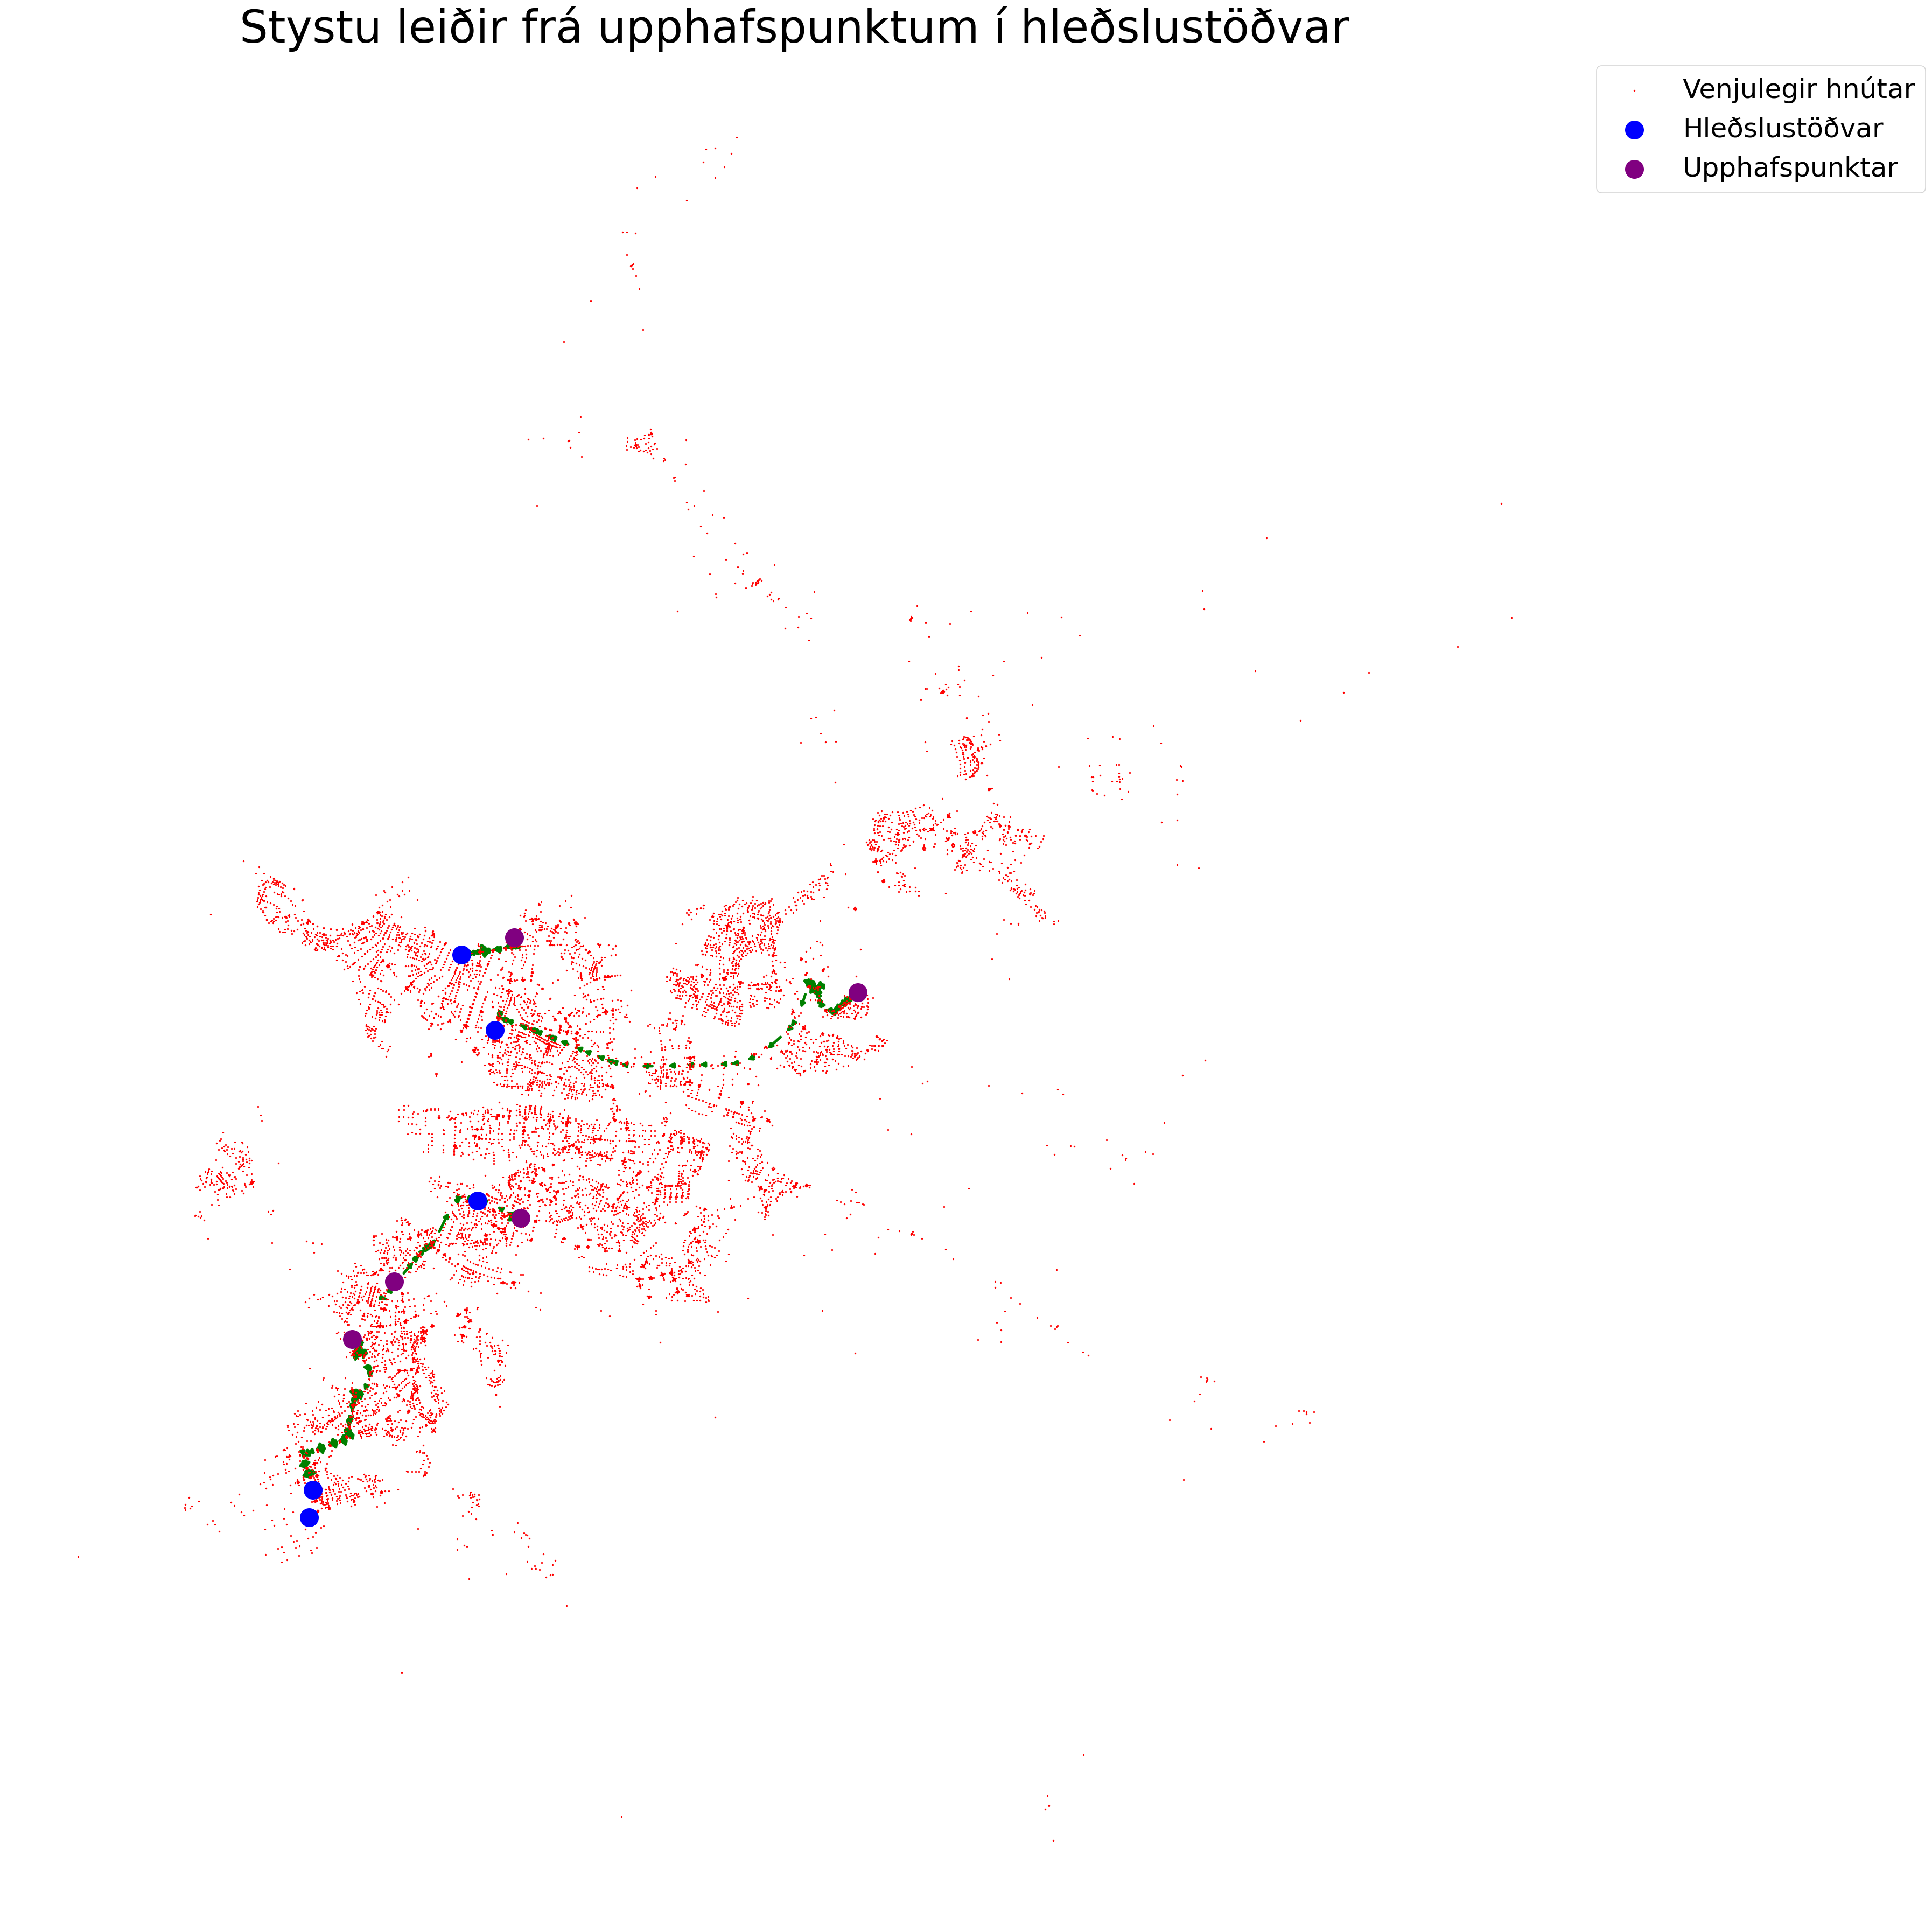

Start Node:  1186616568
https://www.google.com/maps?q=64.0955512,-21.8883475
Start Node:  241784654
https://www.google.com/maps?q=64.0835592,-21.9453247
Start Node:  11641311433
https://www.google.com/maps?q=64.1378368,-21.7361517
Start Node:  11137114625
https://www.google.com/maps?q=64.1481539,-21.8911121
Start Node:  253469037
https://www.google.com/maps?q=64.072827,-21.9643267
Charging Node:  26481023
https://www.google.com/maps?q=64.1449961,-21.914858
Charging Node:  2325888359
https://www.google.com/maps?q=64.1307609,-21.8999934
Charging Node:  5098498898
https://www.google.com/maps?q=64.0393631,-21.9836985
Charging Node:  599332607
https://www.google.com/maps?q=64.0444857,-21.9820114
Charging Node:  297899459
https://www.google.com/maps?q=64.0987287,-21.9076808


In [14]:
# 1. Búa til stefnt net: u -> listi af (v, length)
graph = defaultdict(list)
for _, row in edges_df.iterrows():
    graph[row['u']].append((row['v'], row['length']))


# 2. Finna hvaða hnútar eru hleðslustöðvar (primary == True)
all_charging_stations = nodes_df[nodes_df['primary'] == True]['id'].tolist()

# 3. Velja 5 random hleðslustöðvar með seedi.
random.seed(420)

charging_station_nodes = random.sample(all_charging_stations, 5)


# 4. Velja 5 random upphafshnúta sem EKKI eru hleðslustöðvar
non_stations = nodes_df[~nodes_df['id'].isin(charging_station_nodes)]
start_nodes = random.sample(non_stations['id'].tolist(), 5)

# 5. Reikna stystu vegalengdir að næstu hleðslustöð
shortest_to_station = dijkstra_to_charging(graph, charging_station_nodes)

# 6. Setja niðurstöðurnar í DataFrame
distances_df = pd.DataFrame([
    {'id': node_id, 'distance_to_station': shortest_to_station[node_id]}
    for node_id in nodes_df['id']
])

# 7. Birta hnútana sem eru valdir
for node in start_nodes:
    distance = distances_df.loc[distances_df['id'] == node, 'distance_to_station'].values
    print(f"Distance to station for node {node}: {distance[0]}m")


# 8. Leitarfall: Dijkstra leið frá einum hnút í næstu stöð til að teikna
def dijkstra_path(graph, start, stations):
    dist = {node: float('inf') for node in nodes_df['id']}
    dist[start] = 0
    prev = {}
    heap = [(0, start)]
    while heap:
        d, u = heapq.heappop(heap)
        # ATH
        if u in stations:
            break
        for v, w in graph[u]:
            if dist[v] > d + w:
                dist[v] = d + w
                prev[v] = u
                heapq.heappush(heap, (dist[v], v))
    found = min([(station, dist[station]) for station in stations if dist[station] < float('inf')], key=lambda x: x[1], default=(None, None))
    if found[0] is None:
        return []
    path = []
    current = found[0]
    while current != start:
        path.append(current)
        current = prev[current]
    path.append(start)
    return list(reversed(path))


# 9. Teikna netið 
G = nx.DiGraph()

## notað í A* líka
node_positions = {}

for _, row in nodes_df.iterrows():
    node_id = row['id']
    node_positions[node_id] = (row['x'], row['y'])
    G.add_node(node_id)
for _, row in edges_df.iterrows():
    G.add_edge(row['u'], row['v'], length=row['length'])

plt.figure(figsize=(30, 30), dpi=120)

# 9.1. Venjulegir hnútar
non_charging_nodes = [n for n in G.nodes if n not in charging_station_nodes]
nx.draw_networkx_nodes(G, node_positions, nodelist=non_charging_nodes, node_color='red', node_size=1, label='Venjulegir hnútar')

# 9.2. Hleðslustöðvar
nx.draw_networkx_nodes(G, node_positions, nodelist=charging_station_nodes, node_color='blue', node_size=400, label='Hleðslustöðvar')

# 9.3. Upphafshnútar
nx.draw_networkx_nodes(G, node_positions, nodelist=start_nodes, node_color='purple', node_size=400, label='Upphafspunktar')

# 9.4. Leggir
#nx.draw_networkx_edges(G, node_positions, alpha=0.3, arrows=True, arrowstyle='-|>', arrowsize=8, width=0.3)

# 9.5. Teikna stystu leiðir
for start in start_nodes:
    path = dijkstra_path(graph, start, charging_station_nodes)
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='green', width=3)

plt.title("Stystu leiðir frá upphafspunktum í hleðslustöðvar", fontsize=50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=30)
plt.axis('off')
plt.tight_layout()
plt.show()

for v in start_nodes:
    print('Start Node: ', v)
    print(gmaps_urls[v])

for v in charging_station_nodes:
    print('Charging Node: ', v)
    print(gmaps_urls[v])


In [9]:
shortest_to_station[9207425915]

1618.0305930408974

# Liður 2.3.4 (*)

### Tímamælingar

Mælið tímann sem reikniritið dijkstra tekur að reikna allar fjarlægðir í netinu með fimm
hleðslustöðvum.

In [10]:
start_time = time.time()
shortest_to_station_time = dijkstra_to_charging(graph, charging_station_nodes)
end_time = time.time()

total_time = end_time - start_time

print(f"Tími fyrir Dijkstra fyrir allla punkta í 5 hleðslustöðvar: {total_time:.4f} sek")

Tími fyrir Dijkstra fyrir allla punkta í 5 hleðslustöðvar: 0.0159 sek


# Liður 2.3.5 (**)

### A* reikniritið

Útfærið A⋆ reikniritið sem tekur inn lista af lokahnútum og reiknar fjarlægðir frá öll-
um hnútum í netinu. Sem neðra mat á fjarlægð á milli hnútanna má taka $d(u, v) = \sqrt{(x_u − x_v )^2 + (y_u − y_v )^2}$, þ.e. beina loftlínu milli punktanna. Mælið tíma og berið saman
við reiknirit Dijkstra.

In [11]:
# Útgáfa Sigga
def lower_estimate(node_id, charging_stations, pos):
    x1, y1 = pos[node_id]
    return min(
        sqrt((x1 - pos[station][0])**2 + (y1 - pos[station][1])**2)
        for station in charging_stations
    )

# A*: reiknar stystu leið í einhverja hleðslustöð
# tekur inn net, hleðslustöðvar/target nodes og staðsetningar (x, y) upplýsingar um hvern hnút.  
def a_star_to_charging(graph, charging_nodes, pos):
    dist = {node_id: float('inf') for node_id in nodes_df['id']}
    visited = set()
    heap = []

    # snúa netinu við, til að reikna frá hverjum hnút að stöð
    reversed_graph = defaultdict(list)
    for u in graph:
        for v, weight in graph[u]:
            reversed_graph[v].append((u, weight))
            
    # Upphafsstilla fjarlægðir á hleðslustöðvum sem 0 og setja á heap. 
    for station in charging_nodes:
        dist[station] = 0
        heapq.heappush(heap, (0, station))

    visited_count = 0
        
    # Leit
    while heap:
        _, u = heapq.heappop(heap)
        if u in visited:
            continue
        visited.add(u)
        visited_count += 1

        for v, weight in reversed_graph[u]:
            d = dist[u] + weight
            if d < dist[v]:
                dist[v] = d
                euc = lower_estimate(v, charging_nodes, pos)
                heapq.heappush(heap, (d + euc, v))

    #print(f"A* visited {visited_count} nodes.")
    return dist


# Keyrir á sama tíma og dijkstra því þau leita á svipaðann hátt því euc distance er ekki nógu stórt til að hafa áhrif
# gætum prufað að setja hleðslustöðvar út í öll horn eða eh og sjá hvort það kemur munur 
start_time = time.time()
a_star = a_star_to_charging(graph, charging_station_nodes, node_positions)
end_time = time.time()

total_time = end_time - start_time
print(f"Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar {total_time:.4f} sek")

Tími fyrir A* fyrir alla punkta í 5 hleðslustöðvar 0.0319 sek


# Liður 2.3.6 (**)

### Staðsetning hleðslustöðva

Ef við setjum k hleðslustöðvar í hnúta $v_1, . . . , v_k$ þá látum við markfallið vera

$$F(v_1,...,v_k) = \sum_{u \in V} \underset{i=1,...,k}{min} d(u,v_i)$$

þ.e. fyrir hvern hnút í netinu reiknum við stystu fjarlægð frá honum til næstu hleðslustöðvar
og leggjum saman yfir alla hnúta í netinu.

Finnið bestu lausn fyrir k = 1, með því að prófa alla hnúta sem hægt er að setja
hleðslustöð í og veljið þann sem gefur minnsta markfall. Athugið að eingöngu þeir hnútar
sem eru merktir sem primary geta verið hleðslustöðvar.

In [17]:
best_station = None
mark = float('inf')
count = 0

for station in all_charging_stations:
    distances = dijkstra_to_charging(graph, [station])

    total = 0

    for node_id in distances:
        if distances[node_id] == float('inf'):
            # Bæta við stórri tölu ef dist er inf eins og í hnút 5541083892, bæti við 50km
            total += 50000
        else:
            total += distances[node_id]

    #print(f"Stöð {station} hefur markfallið {total}.")
    count += 1

    if total < mark:
        mark = total
        best_station = station
    #print(f"Minnsta markfallið hingað til er {mark} frá stöð {best_station}.")


print(f"Besta hleðslustöðin er {best_station} með markfallið  {mark}.")
print(gmaps_urls[best_station])
print(f"Fjöldi athugaðra hleðslustöðva er {count}")
    

Besta hleðslustöðin er 34827739 með markfallið  72442102.57913065.
https://www.google.com/maps?q=64.1140749,-21.8457362
Fjöldi athugaðra hleðslustöðva er 1829


# Liður 2.3.7 (**)

### Gráðug reiknirit

Útfærið gráðugt reiknirit sem leitar að bestu lausn fyrir $k = 2, . . . , 10$ með því að leysa
vandamálið fyrir k−1 hleðslustöðvum og bæta þá við þann hnút sem gefur minnsta markfall,
miðað við að ekki sé hægt að breyta $v_1, . . . , v_{k−1}$
Sýnið á korti hvaða hleðslustöðvar eru valdar fyrir k = 10 og mælið tímann sem reikniritið
tekur.

k = 1: 34827739 með markfallið 72442102.5791305
k = 2: 4159611763 með markfallið 55943648.9669397
k = 3: 470316424 með markfallið 44854264.121764205
k = 4: 1204996745 með markfallið 38072391.0504463
k = 5: 470320635 með markfallið 34978692.907693364
k = 6: 253702373 með markfallið 32607435.773555417
k = 7: 2948755314 með markfallið 30478702.90154548
k = 8: 62975525 með markfallið 28429906.153171424
k = 9: 252165232 með markfallið 26957405.504667412
k = 10: 251765347 með markfallið 25531386.67095511
Gráðuga reikniritið tók 332.17 sekúndur


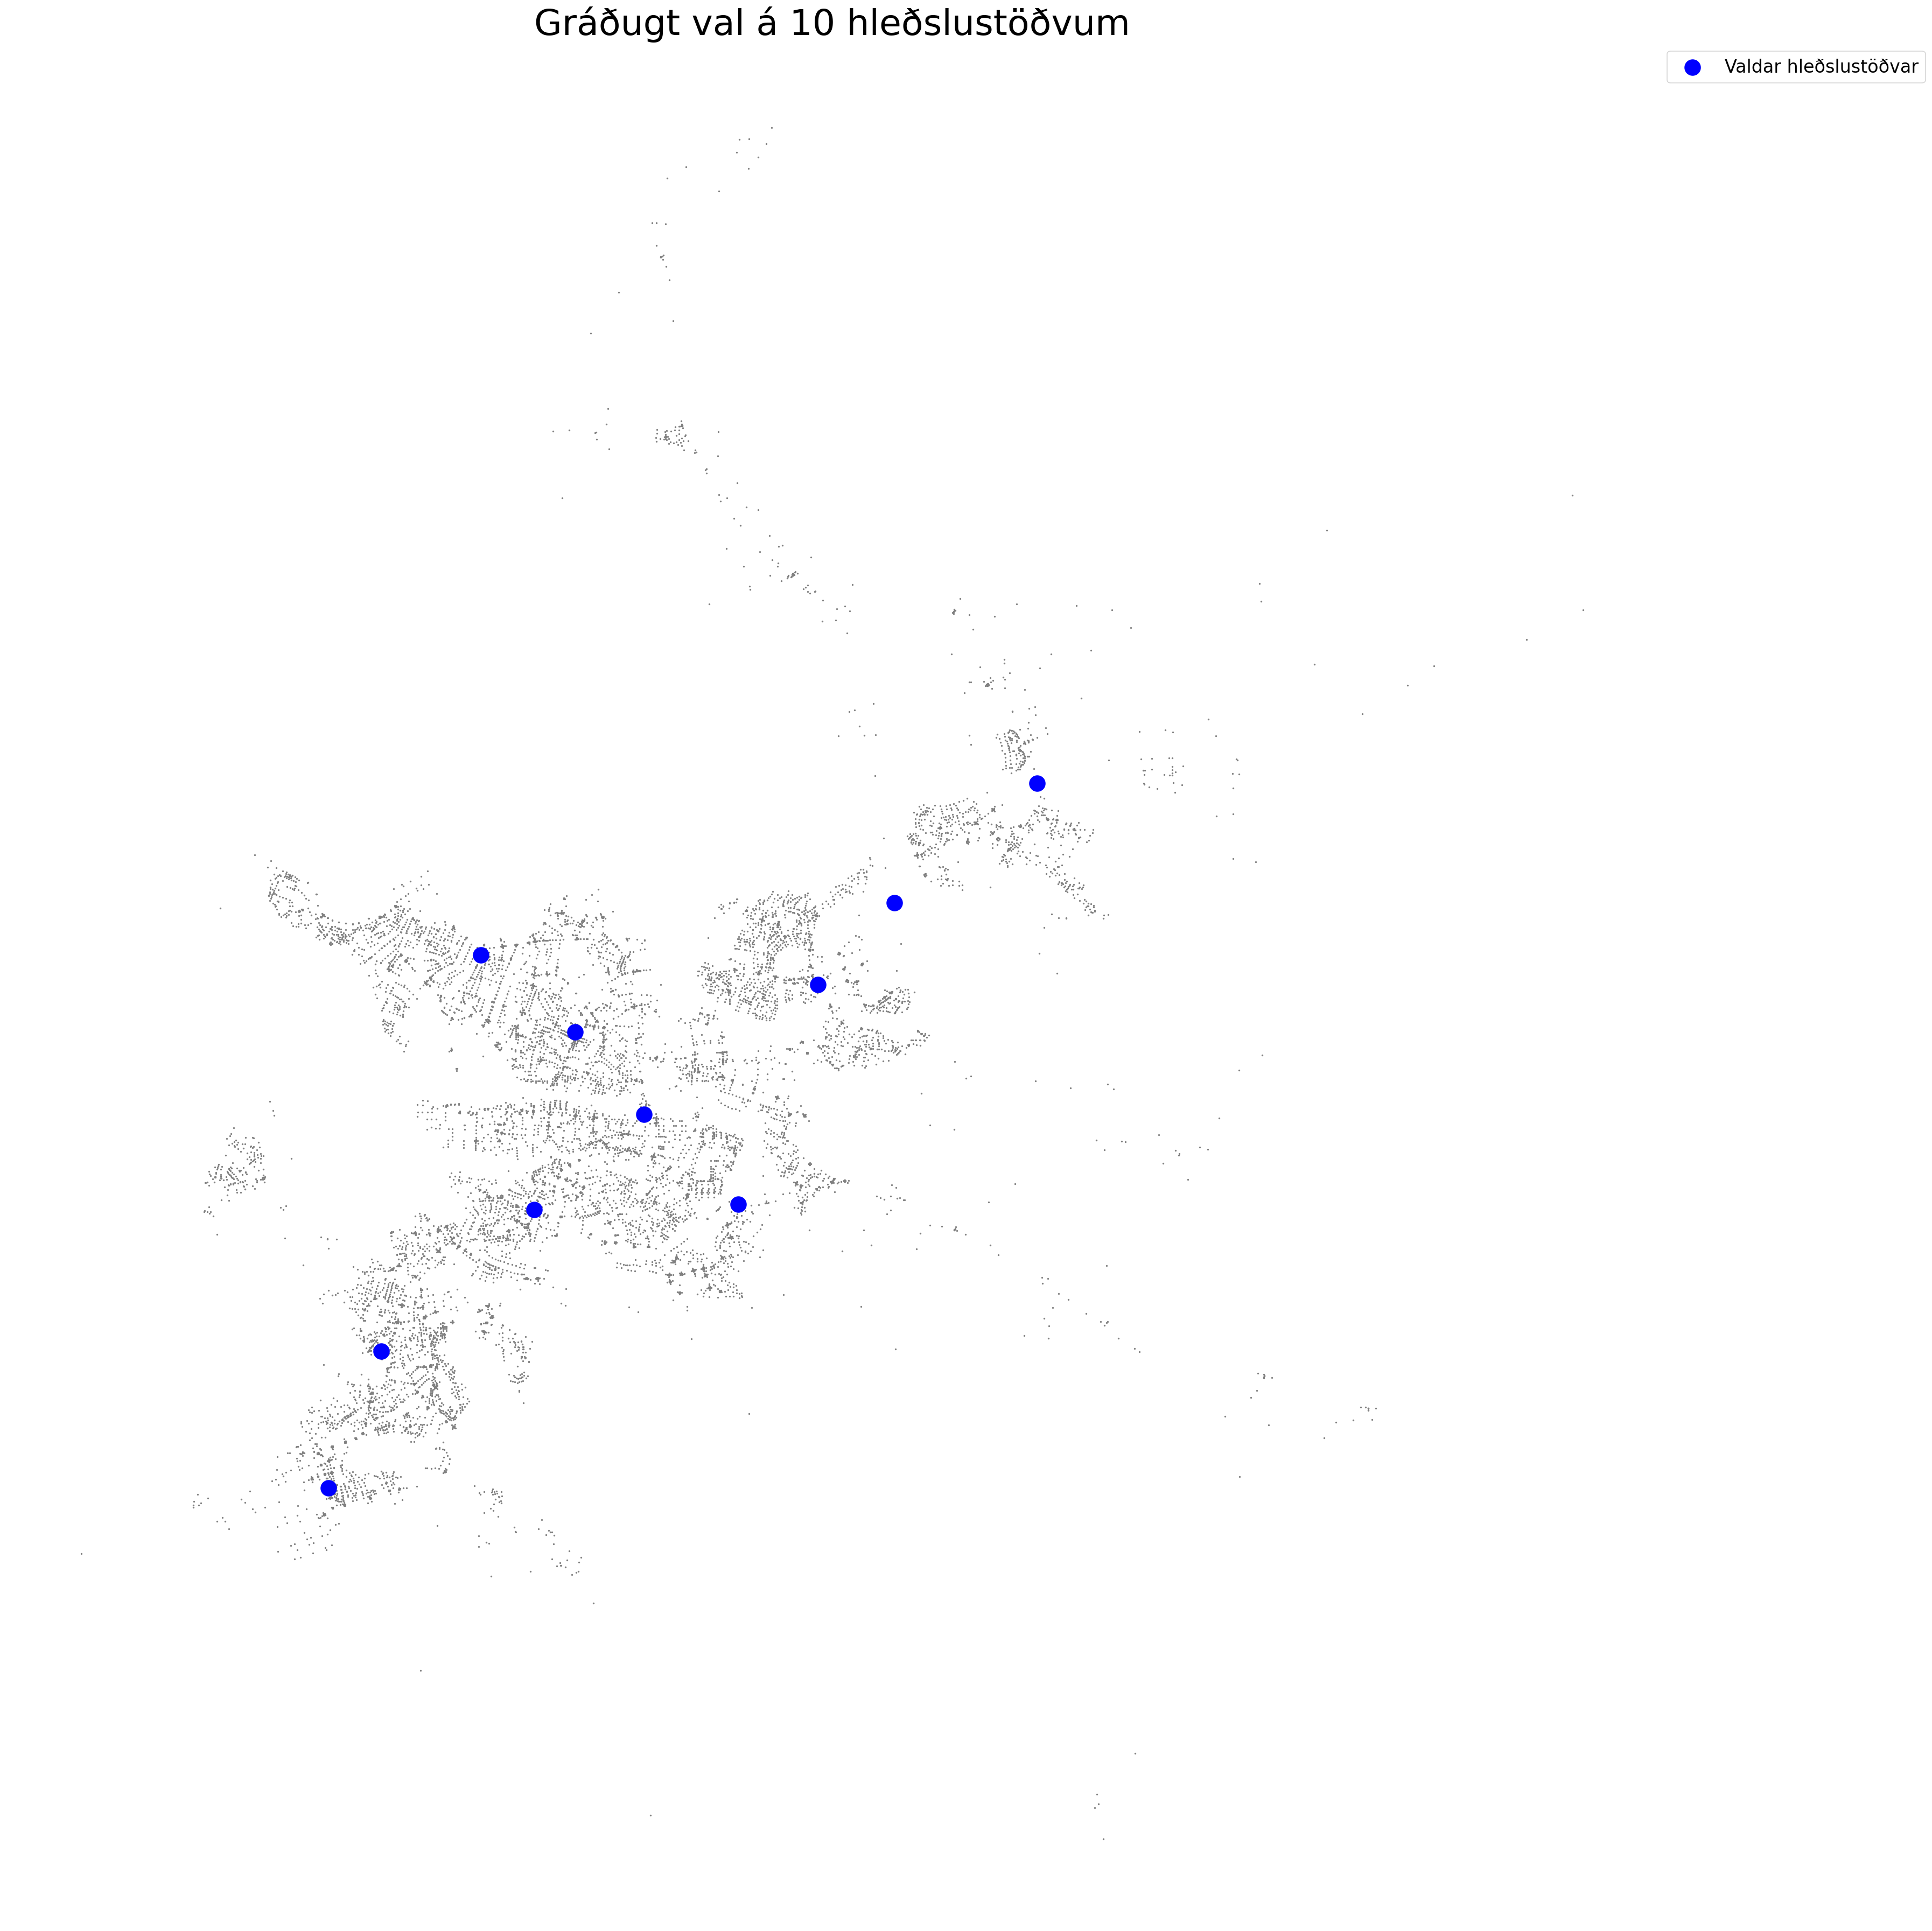

1. Hnútur: 34827739 — https://www.google.com/maps?q=64.1140749,-21.8457362
2. Hnútur: 4159611763 — https://www.google.com/maps?q=64.0698109,-21.9588732
3. Hnútur: 470316424 — https://www.google.com/maps?q=64.1536212,-21.7379318
4. Hnútur: 1204996745 — https://www.google.com/maps?q=64.143833,-21.9158807
5. Hnútur: 470320635 — https://www.google.com/maps?q=64.0963001,-21.8929091
6. Hnútur: 253702373 — https://www.google.com/maps?q=64.1383465,-21.7708875
7. Hnútur: 2948755314 — https://www.google.com/maps?q=64.0973264,-21.805228
8. Hnútur: 62975525 — https://www.google.com/maps?q=64.1759499,-21.6765716
9. Hnútur: 252165232 — https://www.google.com/maps?q=64.0442398,-21.9816643
10. Hnútur: 251765347 — https://www.google.com/maps?q=64.1294204,-21.8754605


In [19]:
def greedy_station_selection(graph, candidate_nodes, k_max):
    chosen_stations = []

    start_time = time.time()

    # --- Finna besta upphafspunkt (k=1): skoðar hvern mögulegan primary hnút ---
    best_station = None
    best_mark = float('inf')
    for node in candidate_nodes:
        # Keyrir dijkstra frá öllum hnútum að þessari stöð
        dists = dijkstra_to_charging(graph, [node])
        # Reiknar markfallið: summa stystu vegalengda (með refsingu fyrir óaðgengilega hnúta)
        total = sum([d if d != float('inf') else 50000 for d in dists.values()])
        if total < best_mark:
            best_mark = total
            best_station = node
    # Bætir bestu stöðinni í listann
    chosen_stations.append(best_station)
    print(f"k = 1: {best_station} með markfallið {best_mark}")

    # --- Gráðugt: Bætir við eina stöð í einu, alltaf þá sem lágmarkar markfallið best ---
    for k in range(2, k_max + 1):
        best_new = None
        best_mark = float('inf')
        for node in candidate_nodes:
            if node in chosen_stations:
                continue
            # Prófar að bæta einum nýjum hnút við núverandi valda hnúta
            test_stations = chosen_stations + [node]
            dists = dijkstra_to_charging(graph, test_stations)
            total = sum([d if d != float('inf') else 50000 for d in dists.values()])
            if total < best_mark:
                best_mark = total
                best_new = node
        # Velur þann hnút sem bætti markfallið mest og bætir við
        chosen_stations.append(best_new)
        print(f"k = {k}: {best_new} með markfallið {best_mark}")

    end_time = time.time()
    print(f"Gráðuga reikniritið tók {end_time - start_time:.2f} sekúndur")

    return chosen_stations

# --- Keyra gráðuga leit fyrir k=10 hleðslustöðvar ---
greedy_stations_k10 = greedy_station_selection(graph, all_charging_stations, 10)


# --- Teikna netið og valdar stöðvar á korti ---
plt.figure(figsize=(30, 30), dpi=120)

# Teikna alla hnúta sem litla gráa punkta (bakgrunnur)
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=1)

# Teikna þær stöðvar sem voru valdar í gráðugu leitinni
nx.draw_networkx_nodes(G, node_positions, nodelist=greedy_stations_k10, node_color='blue', node_size=300, label='Valdar hleðslustöðvar')

# Yfirskrift og lýsing
plt.title("Gráðugt val á 10 hleðslustöðvum", fontsize=40)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()


# --- Prenta staðsetningar á valdum stöðvum með Google Maps tengli ---
for i, s in enumerate(greedy_stations_k10):
    print(f"{i+1}. Hnútur: {s} — {gmaps_urls[s]}")


# Liður 2.3.8 (**)

### Skárri gráðug reiknirit

Gráðuga reikniritið á það til að mála sig út í horn með því að velja lélegan fyrsta hnút.
Breytið leitinni þannig að þið veljið handahófskenndan fyrsta hnút og farið endurkvæmt í
tilfellin $k = 2, . . . , 10.$ Í hverju undirtilfelli finnið þið 2 bestu hnútana sem koma til greina
en eru langt frá hvor öðrum og prófið endurkvæmt alla möguleika. Haldið utan um bestu
lausnina sem finnst fyrir nokkur hanndahófskennda upphafspunkta og sýnið bestu lausn á
korti. Hve mikinn tíma tekur reikniritið ykkar?


--- Trial 1: Starting at node 5027149180 ---
Trial 1 solution: [5027149180, 254042520, 470316424, 35786587, 278773762, 470320635, 26756902, 62975525, 257168753, 2948755314], Objective: 25798966.45

--- Trial 2: Starting at node 5043490914 ---
Trial 2 solution: [5043490914, 241786018, 470316424, 286736055, 1225420709, 2320771866, 257168753, 62975525, 87366131, 6382150947], Objective: 25228624.59

--- Trial 3: Starting at node 1788946949 ---
Trial 3 solution: [1788946949, 34827739, 4159611763, 470316424, 1204996745, 470320635, 253702373, 2948755314, 14772879, 252165232], Objective: 25428824.18

--- Trial 4: Starting at node 87131084 ---
Trial 4 solution: [87131084, 2956073666, 2325775096, 14772879, 1550882370, 14581771, 26756902, 253702373, 2320771866, 6382150947], Objective: 24011460.84

--- Trial 5: Starting at node 1420012506 ---
Trial 5 solution: [1420012506, 10789575590, 1208295841, 254042520, 1334479489, 2948755308, 257168753, 251765347, 470320635, 252165202], Objective: 24996594.

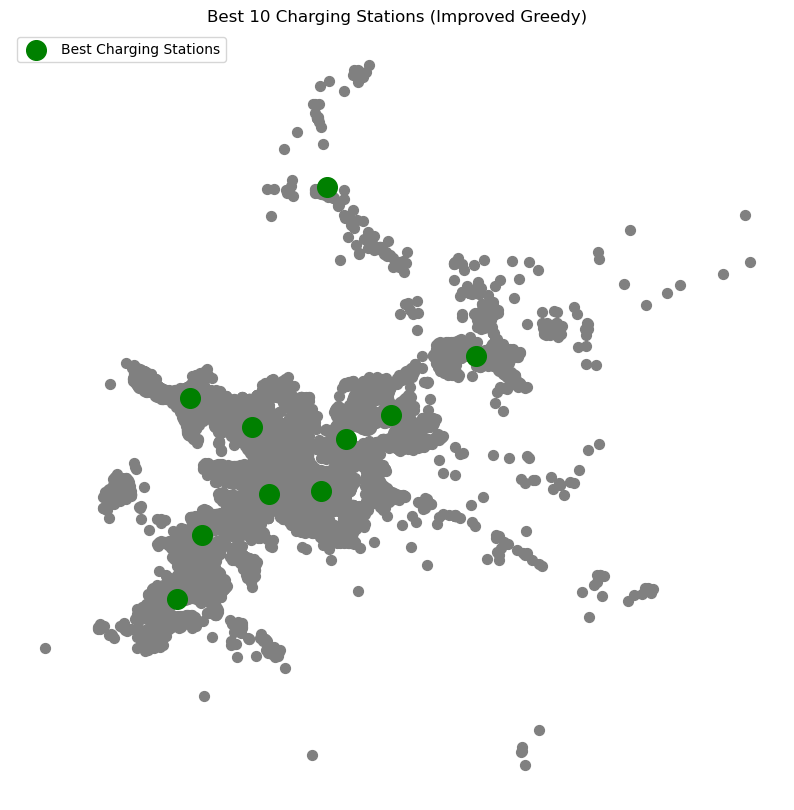

In [22]:
import random
import time
import matplotlib.pyplot as plt
import networkx as nx

def compute_objective(graph, charging_nodes):
    dists = dijkstra_to_charging(graph, charging_nodes)
    return sum([d if d != float('inf') else 50000 for d in dists.values()])

def improved_greedy(graph, candidates, current_stations, k, cached_improvements=None):
    if cached_improvements is None:
        cached_improvements = {}
    
    if len(current_stations) == k:
        return current_stations, compute_objective(graph, current_stations)
    
    curr_cost = compute_objective(graph, current_stations)
    
    candidate_list = []
    for node in candidates:
        if node in current_stations:
            continue
        if node not in cached_improvements:
            candidate_cost = compute_objective(graph, current_stations + [node])
            improvement = curr_cost - candidate_cost
            cached_improvements[node] = improvement
        candidate_list.append(node)
    
    candidate_list.sort(key=lambda node: cached_improvements[node], reverse=True)
    
    best_two = []
    for node in candidate_list:
        # Ef við höfum þegar tvö besta gildi og cached gildið er minna en lægsta bót,
        # sleppum við frekari útreikningum.
        if len(best_two) == 2 and cached_improvements[node] < min(x[2] for x in best_two):
            break
        candidate_cost = compute_objective(graph, current_stations + [node])
        new_imp = curr_cost - candidate_cost
        cached_improvements[node] = new_imp
        best_two.append((node, candidate_cost, new_imp))
        best_two = sorted(best_two, key=lambda tup: tup[1])[:2]
    
    best_result = None
    best_value = float('inf')
    for candidate, candidate_cost, _ in best_two:
        new_stations = current_stations + [candidate]
        result, val = improved_greedy(graph, candidates, new_stations, k, cached_improvements)
        if val < best_value:
            best_value = val
            best_result = result
    
    return best_result, best_value

def run_improved_greedy_multiple(graph, candidates, k=10, trials=5):
    best_overall = None
    best_score = float('inf')
    start_time = time.time()

    for i in range(trials):
        first = random.choice(candidates)
        print(f"\n--- Trial {i+1}: Starting at node {first} ---")
        result, score = improved_greedy(graph, candidates, [first], k)
        print(f"Trial {i+1} solution: {result}, Objective: {score:.2f}")
        if score < best_score:
            best_overall = result
            best_score = score

    end_time = time.time()
    print(f"\nTotal time: {end_time - start_time:.2f} seconds")
    return best_overall, best_score


# Keyrðu improved_greedy með nokkrum tilraunum
best_improved_stations, best_mark_value = run_improved_greedy_multiple(graph, all_charging_stations, k=10, trials=5)

print("\nBest solution found by improved_greedy:")
for i, s in enumerate(best_improved_stations):
    print(f"{i+1}. Node: {s} — {gmaps_urls[s]}")
print(f"Objective: {best_mark_value:.2f}")

plt.figure(figsize=(30, 30))
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=10)
nx.draw_networkx_nodes(G, node_positions, nodelist=best_improved_stations, node_color='green', node_size=300, label='Best Charging Stations')
plt.title("Best 10 Charging Stations (Improved Greedy)")
plt.legend(loc='upper left')
plt.axis('off')
plt.show()



Trial 1
Lausn í tilraun 1: [1232404991, 1203320099, 254042520, 470316424, 269072778, 1203904360, 470320635, 62975525, 251765347, 2948755314] — Markfall: 26001777.42

Trial 2
Lausn í tilraun 2: [452061450, 1896201758, 254042520, 35786587, 36166172, 14772879, 1203904360, 26756902, 6382150947, 470320635] — Markfall: 24791297.65

Trial 3
Lausn í tilraun 3: [1228091989, 241786018, 470316424, 286732389, 26471945, 257168753, 2320771866, 62975525, 87366131, 2018901752] — Markfall: 24969205.61

Trial 4
Lausn í tilraun 4: [2277872099, 1208295841, 241779370, 34512506, 14772879, 2948755308, 257168753, 26756902, 6382150947, 251765347] — Markfall: 24279304.37

Trial 5
Lausn í tilraun 5: [26471934, 1203320099, 241779370, 470316424, 34186925, 1203904360, 470320635, 62975525, 2948755314, 6382150947] — Markfall: 25194764.28

✨ Besta lausnin yfir allt: [2277872099, 1208295841, 241779370, 34512506, 14772879, 2948755308, 257168753, 26756902, 6382150947, 251765347]
Markfall: 24279304.37
⏱️ Heildartími: 421

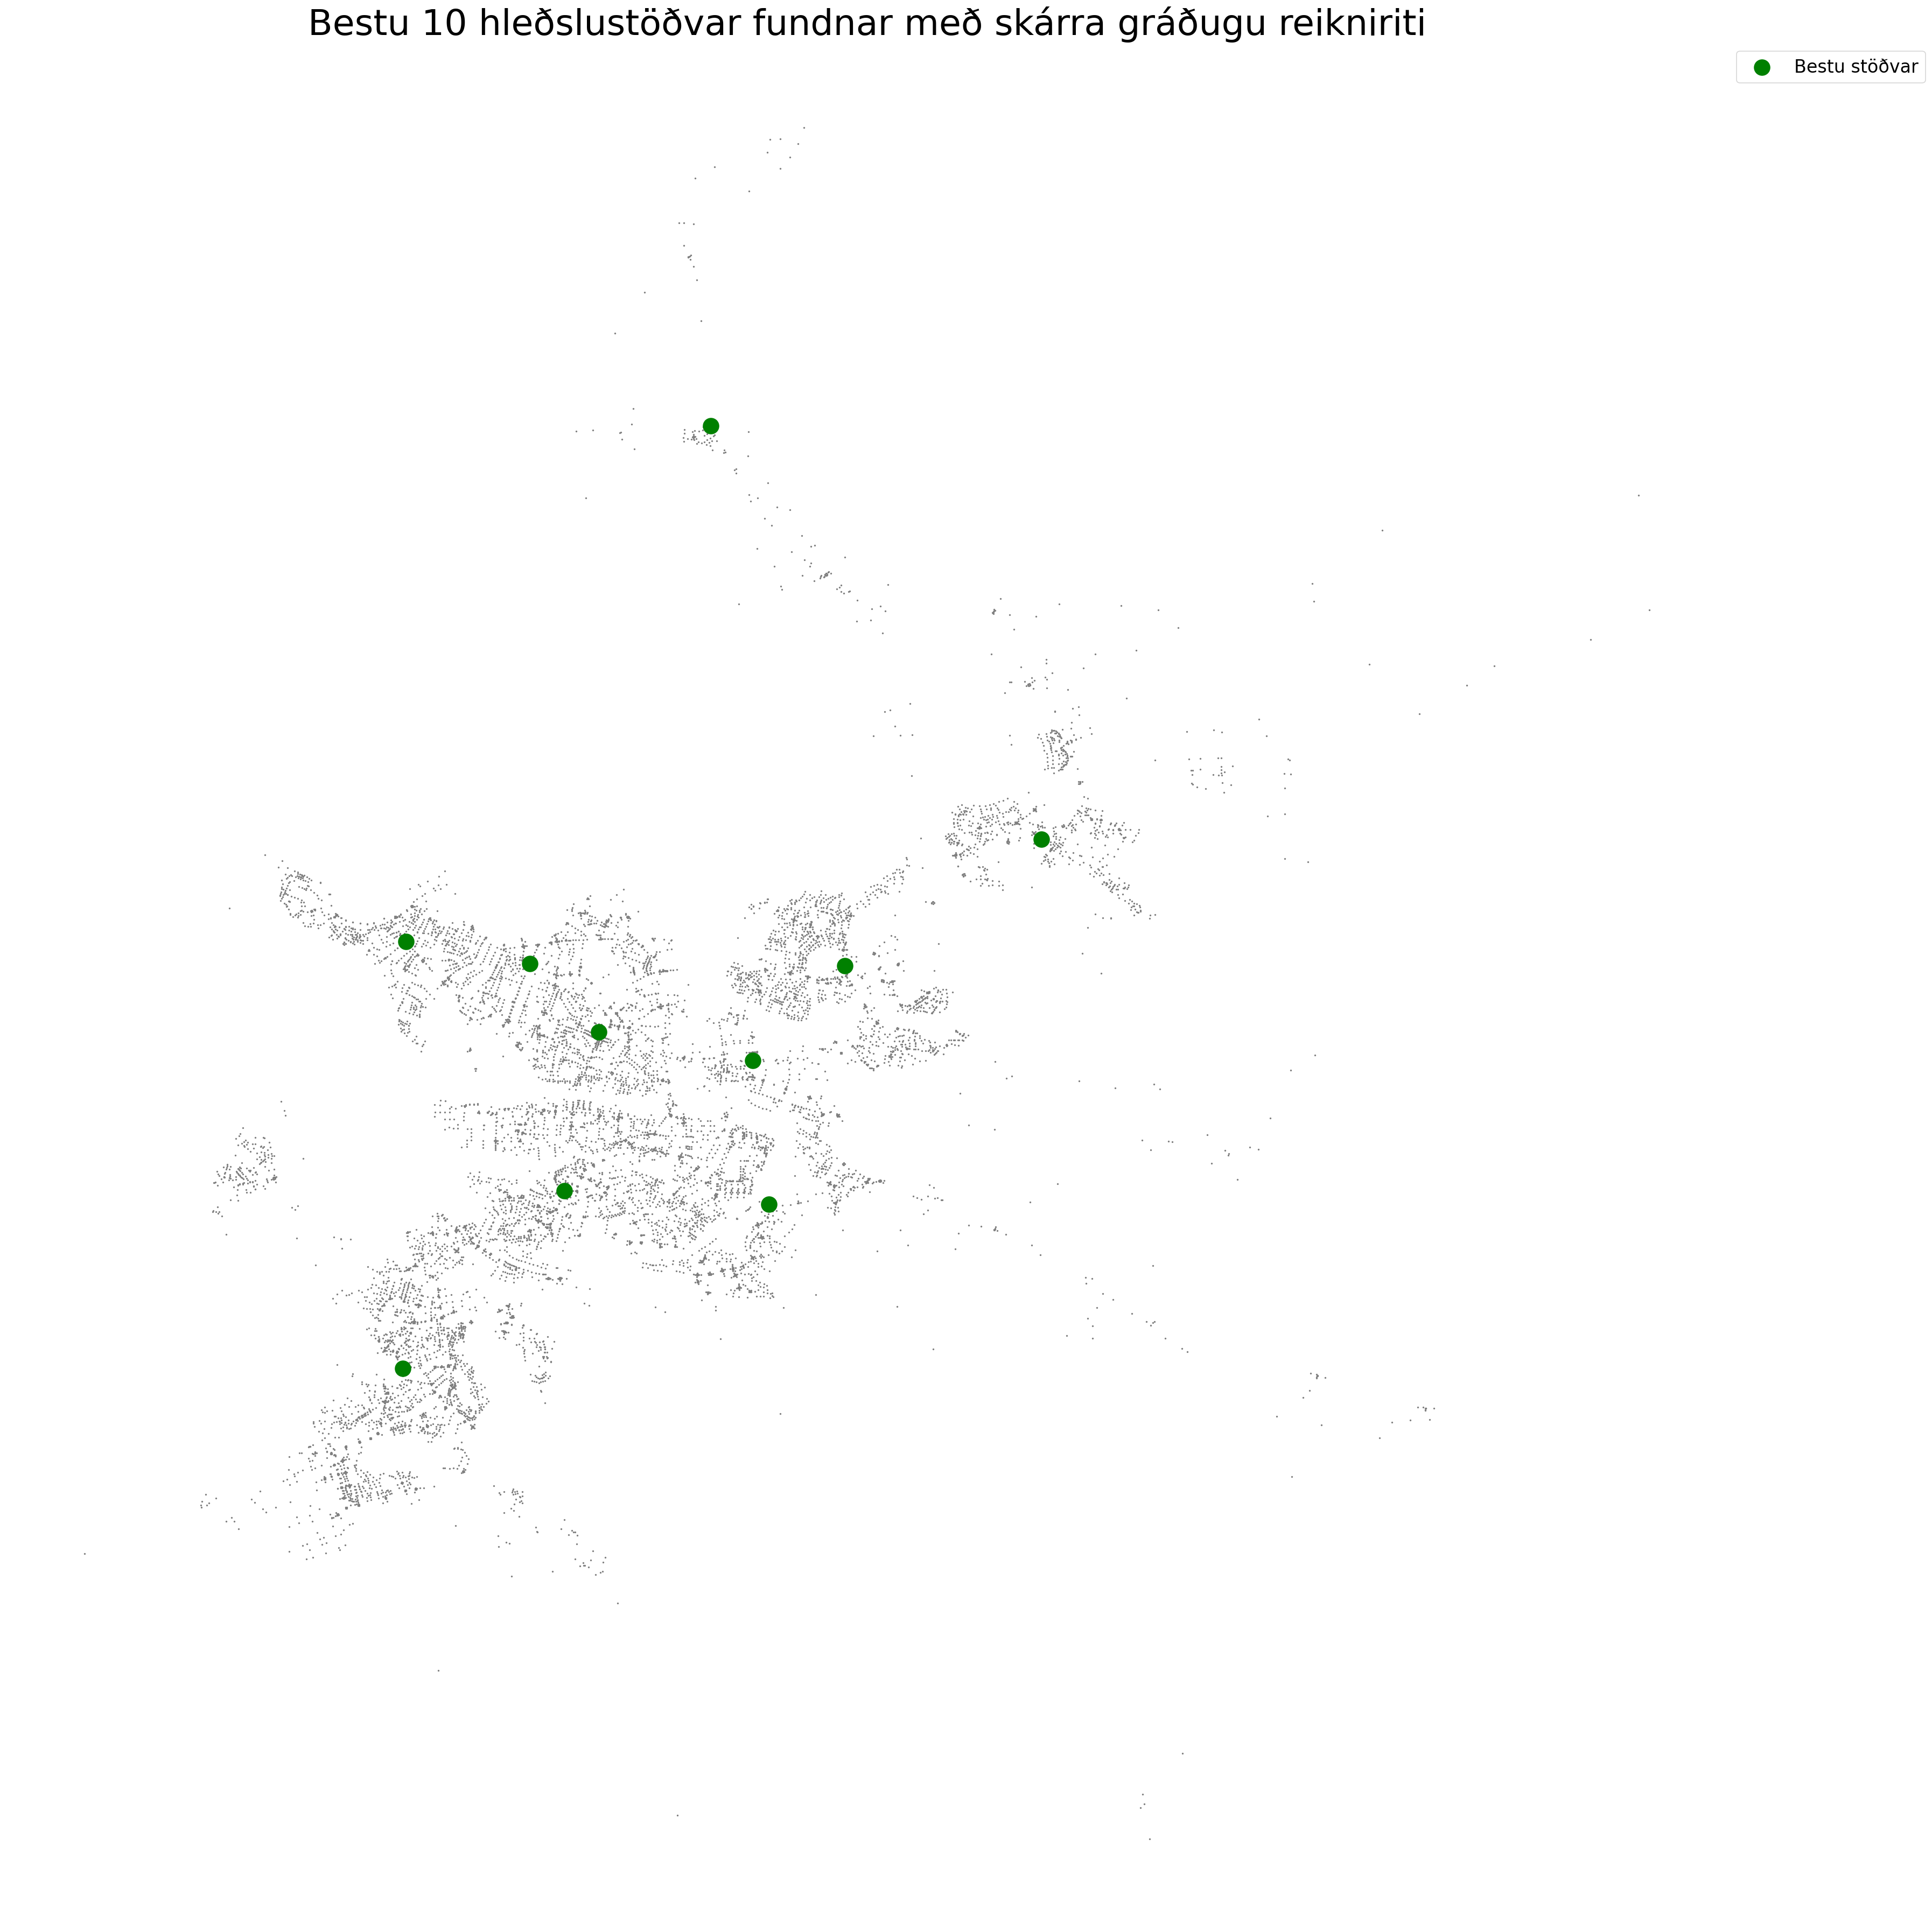

In [21]:
def compute_objective(graph, charging_nodes):
    dists = dijkstra_to_charging(graph, charging_nodes)
    return sum([d if d != float('inf') else 50000 for d in dists.values()])

# Skárra gráðugt – recursive variant með bestu tveimur möguleikum
def improved_greedy(graph, candidates, current_stations, k):
    if len(current_stations) == k:
        return current_stations, compute_objective(graph, current_stations)

    best_two = []
    for node in candidates:
        if node in current_stations:
            continue
        test_stations = current_stations + [node]
        mark = compute_objective(graph, test_stations)
        best_two.append((node, mark))
    
    # Veljum 2 bestu hnútana sem ekki eru nú þegar í listanum
    best_two = sorted(best_two, key=lambda x: x[1])[:2]

    best_result = None
    best_value = float('inf')

    for node, _ in best_two:
        new_stations = current_stations + [node]
        result, val = improved_greedy(graph, candidates, new_stations, k)
        if val < best_value:
            best_value = val
            best_result = result

    return best_result, best_value

def fast_improved_greedy(graph, candidates, k=10, trials=5, beam_width=2):
    best_overall = None
    best_score = float('inf')
    start_time = time.time()

    for t in range(trials):
        print(f"\nTrial {t+1}")
        first = random.choice(candidates)
        beams = [([first], compute_objective(graph, [first]))]

        for step in range(1, k):
            new_beams = []
            for current, current_score in beams:
                for node in candidates:
                    if node in current:
                        continue
                    new_set = current + [node]
                    score = compute_objective(graph, new_set)
                    new_beams.append((new_set, score))
            # Halda aðeins bestu beam_width lausnunum áfram
            new_beams.sort(key=lambda x: x[1])
            beams = new_beams[:beam_width]

        best_trial = beams[0]
        print(f"Lausn í tilraun {t+1}: {best_trial[0]} — Markfall: {best_trial[1]:.2f}")
        if best_trial[1] < best_score:
            best_overall = best_trial[0]
            best_score = best_trial[1]

    end_time = time.time()
    print(f"\n Besta lausnin yfir allt: {best_overall}")
    print(f"Markfall: {best_score:.2f}")
    print(f"⏱ Heildartími: {end_time - start_time:.2f} sek")

    return best_overall, best_score


def run_improved_greedy_multiple(graph, candidates, k=10, trials=5):
    best_overall = None
    best_score = float('inf')
    start_time = time.time()

    for i in range(trials):
        first = random.choice(candidates)
        print(f"\n--- Trial {i+1}: Byrjum á hnúti {first} ---")
        result, score = improved_greedy(graph, candidates, [first], k)
        print(f"Lausn í þessu tilviki: {result}, markfall: {score:.2f}")
        if score < best_score:
            best_overall = result
            best_score = score

    end_time = time.time()
    print(f"\n Heildartími: {end_time - start_time:.2f} sek")
    return best_overall, best_score

#best_improved_stations, best_mark_value = run_improved_greedy_multiple(graph, all_charging_stations, k=10, trials=5)
best_improved_stations, best_mark_value = fast_improved_greedy(graph, all_charging_stations, k=10, trials=5, beam_width=2)


print("\n Besta lausnin sem fannst:")
for i, s in enumerate(best_improved_stations):
    print(f"{i+1}. Hnútur: {s} — {gmaps_urls[s]}")
print(f"Markfall: {best_mark_value:.2f}")

plt.figure(figsize=(30, 30), dpi=120)

# Allir hnútar
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=1)

# Valdar hleðslustöðvar
nx.draw_networkx_nodes(G, node_positions, nodelist=best_improved_stations, node_color='green', node_size=300, label='Bestu stöðvar')

plt.title("Bestu 10 hleðslustöðvar fundnar með skárra gráðugu reikniriti", fontsize=40)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()


# Liður 2.3.9 (***)

### Nákvæm lausn fyrir k=10

Finnið bestu lausn fyrir k = 10 með því að setja vandamálið upp sem heiltölubestunarverk-
efni (e. integer linear program) og leysa það með því að nota pakka á borð við Gurobi eða
OR-tools. Athugið að verkefnið gæti verið of stórt fyrir þessa pakka. Nýtið ykkur götur í
hverfum eru oft teng við primary hnúta í gegnum einn veg, þá er hægt að einfalda netið með
því að skipta þessum hverfum út fyrir einn hnút sem tengir sameiginlegan primary hnút.
Þessa leggi er hægt að finna með DFS. Sýnið bestu lausnina á korti og mælið tímann sem
heiltölubestunarverkefnið tekur.
3


## Heiltölubestunarlíkan (ILP) fyrir staðsetningu hleðslustöðva

Við viljum velja $k = 10$ hnúta úr mengi primary hnúta, þannig að hver hnútur $u \in V$ hafi sem stystan veg að einhverri stöð, og heildarfjarlægðin yfir alla hnúta í netinu sé sem minnst.

---

### Markfall

Markmiðið er að lágmarka summu stystu fjarlægða frá öllum hnútum $u \in V$ í einhverja af valdu hleðslustöðvunum:

$$
\min_{v_1, \dots, v_k} F(v_1, \dots, v_k) = \sum_{u \in V} \min_{i = 1, \dots, k} d(u, v_i)
$$

---

### Breytur

Við skilgreinum eftirfarandi breytur:

- $x_j \in \{0, 1\}$ fyrir hvern $j \in P$, þar sem $P$ er mengi primary hnúta.  
  Ef $x_j = 1$, þá er hnútur $j$ valinn sem hleðslustöð.

- $y_u \in \mathbb{R}_{\ge 0}$ fyrir hvern $u \in V$ – táknar stystu fjarlægð frá $u$ í einhverja af völdu stöðvunum.

- $d(u, j)$ táknar stystu vegalengd frá hnút $u$ til hleðslustöðvar $j$ (forreiknað).

---

### Líkan (ILP)

**Markfall:**

$$
\min \sum_{u \in V} y_u
$$

**Takmarkanir:**

1. Velja nákvæmlega 10 stöðvar:

$$
\sum_{j \in P} x_j = 10
$$

2. Fjarlægð $y_u$ má ekki vera minni en fjarlægðin í einhverja virka stöð $j$:

$$
y_u \leq d(u, j) + M \cdot (1 - x_j) \quad \forall u \in V,\ \forall j \in P
$$

Hér er $M$ mjög stór tala (t.d. $M = 50000$) sem tryggir að takmörkunin sé óvirk ef $x_j = 0$.

---

### Skýring

Þar sem við getum ekki beint notað $\min$ í línulegum líkönum, þá notum við hjálparbreytur $y_u$ til að halda utan um stystu fjarlægðir frá hverjum hnút $u$ í einhverja virka stöð.

Takmarkanirnar tryggja að $y_u$ verður að vera minni en eða jöfn $d(u, j)$ fyrir allar virkar stöðvar $j$.  
Ef $x_j = 0$, þá virkar þessi takmörkun ekki vegna stóru $M$ gildisins (big-M brella).

Þetta líkangerð gerir okkur kleift að nota Gurobi eða annan ILP leysa til að finna nákvæmlega bestu staðsetningarnar fyrir hleðslustöðvar í netinu.


In [23]:
from gurobipy import Model, GRB, quicksum
import numpy as np
import heapq
import time
import matplotlib.pyplot as plt
import networkx as nx

# ---------- PARTI 1: Úthluta hverjum hnút við næsta primary hnút með fjöl-uppruna Dijkstra ----------
def assign_nodes_to_closest_primary(graph, nodes_df):
    """
    Úthlutar hverjum hnút við næsta primary hnút með fjöl-uppruna Dijkstra.
    Input:
      - graph: net (hér er gert ráð fyrir að graph[node] skili lista af tuples: (neighbor, weight))
      - nodes_df: pandas dataframe með reitum "id" og "primary" (boolean)
    Skilar assignment: orðabók sem tengir hvern hnút (id) við primary hnútinn sem honum er nálast.
    """
    primary_nodes = list(nodes_df[nodes_df["primary"] == True]["id"])
    assignment = {}
    # Upphafstillum fjarlægðir fyrir hvern hnút með óendanlegu gildi.
    dist = {node: float('inf') for node in nodes_df["id"]}
    # Forgangsbiðröð með tuples: (fjarlægð, núverandi hnútur, primary uppruni)
    pq = []
    
    # Byrjum á að bæta hverjum primary hnút við, með fjarlægð 0 (sjálfur)
    for p in primary_nodes:
        heapq.heappush(pq, (0, p, p))
        dist[p] = 0
        assignment[p] = p
        
    # Keyrum Dijkstra-leitina
    while pq:
        d, node, primary = heapq.heappop(pq)
        if d > dist[node]:
            continue
        # Það er gert ráð fyrir að graph[node] skili (neighbor, weight) tuples
        for neighbor, weight in graph[node]:
            new_dist = d + weight
            if new_dist < dist[neighbor]:
                dist[neighbor] = new_dist
                assignment[neighbor] = primary
                heapq.heappush(pq, (new_dist, neighbor, primary))
                
    return assignment

# ---------- PARTI 2: Aggregation Candidate primary hnúta (samleiðsla) ----------
def aggregate_candidates(candidates, node_positions, threshold):
    """
    Sameinar candidate primary hnúta sem eru innan fyrir gefins fjarlægðarþols.
    Fyrir hvern candidate athugum við hvort hann er of nálægt einhverjum þegar valnum.
    """
    aggregated = []
    for candidate in candidates:
        pos = np.array(node_positions[candidate])
        too_close = False
        for rep in aggregated:
            rep_pos = np.array(node_positions[rep])
            # Ef euclidíska fjarlægðin er minni en threshold, teljum við hann "of nálægann"
            if np.linalg.norm(pos - rep_pos) < threshold:
                too_close = True
                break
        if not too_close:
            aggregated.append(candidate)
    return aggregated

# ---------- PARTI 2.5: Pruning – Fjarlæging "leaf" neighbourhoods ----------
def prune_leaf_neighborhoods(G, primary_nodes):
    """
    Fjarlægir þá hnútana úr netinu G sem eru tengdir við eitthvað annað en með fleiri en einum veginni.
    Þeir hnútarnir sem eru aðeins tengdir með einum bandi ("leaf nodes")
    og eru EKKI primary hnútar eru fjarlægðir til að einfalda netið.
    Primary hnútar eru alltaf haldnir.
    
    Input:
      - G: networkx graph
      - primary_nodes: listi af primary hnútum (umsækjenda) sem við viljum halda óbreyttum.
    Skilar listanum af hnúta eftir pruning.
    """
    pruned = set(primary_nodes)  # Alltaf halda primary hnútum
    for node in G.nodes():
        if node in primary_nodes:
            continue  # Hér er um primary hnút að ræða
        # Ef hnúturinn hefur gráðuna 1 (er leaf) þá sleppum við honum.
        if G.degree(node) > 1:
            pruned.add(node)
    return list(pruned)

# ---------- PARTI 3: Undirbúning einfalds nets og fjarlægðartöflu (distance table) ----------
# Gerum ráð fyrir að 'nodes_df' sé til og inneha reitina "id" og "primary"

# Til dæmis, búum til gervi nodes_df fyrir úrtak:
import pandas as pd
node_ids = list(range(100))   # Dæmi: 100 hnútar
# Setjum tilviljunarkennt 15% af hnútunum sem primary
primary_flags = [True if np.random.rand() < 0.15 else False for _ in node_ids]
nodes_df = pd.DataFrame({"id": node_ids, "primary": primary_flags})

# Gerum ráð fyrir að 'graph' sé skilgreint sem adjacency list. Við getum til dæmis notað networkx og umbreytt því.
# Hér notum við networkx til að búa til grafer en umbreytum í dict með lista af tuples fyrir simplicity í Dijkstra.
G = nx.erdos_renyi_graph(100, 0.05, seed=42)
node_positions = nx.spring_layout(G, seed=42)  # Til að geta teiknað
# Búum til adjacency list með þyngd (tilviljunarkennd þyngd)
graph = {}
for node in G.nodes():
    graph[node] = []
    for nbr, attrs in G[node].items():
        # Gefum hverjum brúnarásum tilviljunarkennt þyngdar gildi ef ekki til staðar
        weight = attrs.get("weight", np.random.uniform(1, 10))
        graph[node].append((nbr, weight))

# Fyrst úthlutum við hnúta við nærasta primary hnút með Dijkstra.
component_map = assign_nodes_to_closest_primary(graph, nodes_df)

# Við sameinum þá primary hnúta sem komu í assignmentinu.
compressed_nodes = list(set(component_map.values()))
print(f"Fjöldi hnútapakka sem voru sameinaðir: {len(compressed_nodes)}")

# Umsækjenda primary hnútar í einfölduðu netinu
all_nodes_simplified = compressed_nodes
primary_nodes_simplified = compressed_nodes  # Primary candidate hnútarnir

# Byrjum á að sameina candidates sem eru nálægt hvor öðrum (samleiðsla) – til dæmis með threshold 50 (mælikvarði samhliða node_positions)
THRESHOLD_DISTANCE = 50  
aggregated_candidates = aggregate_candidates(primary_nodes_simplified, node_positions, THRESHOLD_DISTANCE)
print(f"Fjöldi umsækjenda hnúta eftir samleiðslu: {len(aggregated_candidates)}")

# Uppfærum einfölduðu mengi hnúta með samleiðslunni:  
primary_nodes_simplified = aggregated_candidates

# Nú einfaldaum við netið með pruning: fjarlægjum leaf neighbourhoods sem eru ekki primary.
all_nodes_simplified = prune_leaf_neighborhoods(G, primary_nodes_simplified)
print(f"Fjöldi hnúta eftir pruning á leaf neighbourhoods: {len(all_nodes_simplified)}")

# Nú reiknum við fjarlægðartöflu fyrir einfaldan netgrunn.
print("Reikna fjarlægðartöflu fyrir einfölduðu netgrunn...")
d_simplified = {}
# Fyrst reiknum við fjarlægðir frá hverri umsækjandi stöð (primary node) með Dijkstra.
dists_to_each_station = {}
for station in primary_nodes_simplified:
    dists_to_each_station[station] = {}
    # Fyrir hverja primary stöð reiknum við Dijkstra frá henni yfir 'graph'
    # Hér nýtum við einfaldan aðferð sem framkvæmir Dijkstra á 'graph' sem er adjacency list.
    # (Þessi útfærsla er einföld; fyrir stór net mætti nota hraðari aðferðir.)
    distances = {node: float('inf') for node in graph}
    distances[station] = 0
    pq = [(0, station)]
    while pq:
        d, node = heapq.heappop(pq)
        if d > distances[node]:
            continue
        for neighbor, weight in graph[node]:
            if distances[node] + weight < distances[neighbor]:
                distances[neighbor] = distances[node] + weight
                heapq.heappush(pq, (distances[neighbor], neighbor))
    dists_to_each_station[station] = distances

# Nú búum við til fjarlægðartöflu d_simplified[u][j] fyrir hvern hnút u (í all_nodes_simplified)
# og hvern umsækjanda j (primary_nodes_simplified). Ef engin tenging, setjum við gildi 5000.
for u in all_nodes_simplified:
    d_simplified[u] = {}
    for j in primary_nodes_simplified:
        dist = dists_to_each_station[j][u]
        d_simplified[u][j] = dist if dist != float('inf') else 5000

# ---------- PARTI 4: Setja upp og leysa ILP líkanið með Gurobi ----------
print("Setja upp Gurobi líkan með einföldun...")

model = Model("simplified_ilp")
model.Params.OutputFlag = 0  # Slökkum á úttaki leysirinnar

# Ákvörðunarbreytur
x = {j: model.addVar(vtype=GRB.BINARY, name=f"x_{j}") for j in primary_nodes_simplified}
y = {u: model.addVar(vtype=GRB.CONTINUOUS, name=f"y_{u}") for u in all_nodes_simplified}

# Takmörkun: Veljum nákvæmlega 10 stöðvar
model.addConstr(quicksum(x[j] for j in primary_nodes_simplified) == 10)

# Tengitakmörkun: Fyrir hvern hnút u í einfölduðu netinu tryggjum við að y[u] sé
# ekki stærra en fjarlægðin frá u til hvaða umsækjanda j sem er valinn (big-M nálgun)
M = 50000
for u in all_nodes_simplified:
    for j in primary_nodes_simplified:
        model.addConstr(y[u] <= d_simplified[u][j] + M * (1 - x[j]))

# Markmið: Minnka heildarfjarlægð (summa y[u] fyrir alla hnútana í einfölduðu netinu)
model.setObjective(quicksum(y[u] for u in all_nodes_simplified), GRB.MINIMIZE)

# Leysum ILP-verkefnið og mælum tímann sem það tekur.
start_time = time.time()
model.optimize()
end_time = time.time()
print(f"ILP með einföldun tók {end_time - start_time:.2f} sek")

# ---------- PARTI 5: Sækjum og birtum lausnina ----------
if model.status == GRB.OPTIMAL:
    selected_ilp_simplified = [j for j in primary_nodes_simplified if x[j].X > 0.5]
    print("Valdar hleðslustöðvar í einfölduðu neti:")
    for i, node in enumerate(selected_ilp_simplified):
        print(f"{i+1}. Hnútur {node} — {gmaps_urls.get(node, 'URL ekki til')}")
    
    # Teiknum lausnina á netinu
    plt.figure(figsize=(30, 30), dpi=120)
    nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=1)
    nx.draw_networkx_nodes(G, node_positions, nodelist=selected_ilp_simplified, node_color='orange', node_size=300, label='ILP val (þjappað)')
    plt.title("Bestu 10 hleðslustöðvar með netþjöppun (ILP)", fontsize=40)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Gurobi fann ekki bestu lausn (status:", model.status, ")")

# Endanlega prentun lausna
selected_ilp_simplified = [j for j in primary_nodes_simplified if x[j].X > 0.5]
print("Endanlegar valdar hleðslustöðvar í einfölduðu neti:")
for i, node in enumerate(selected_ilp_simplified):
    print(f"{i+1}. Hnútur {node} — {gmaps_urls.get(node, 'URL ekki til')}")
    
plt.figure(figsize=(30, 30), dpi=120)
nx.draw_networkx_nodes(G, node_positions, node_color='gray', node_size=1)
nx.draw_networkx_nodes(G, node_positions, nodelist=selected_ilp_simplified, node_color='orange', node_size=300, label='ILP val (þjappað)')
plt.title("Bestu 10 hleðslustöðvar með netþjöppun (ILP)", fontsize=40)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()


Fjöldi hnútapakka sem voru sameinaðir: 15
Fjöldi umsækjenda hnúta eftir samleiðslu: 1
Fjöldi hnúta eftir pruning á leaf neighbourhoods: 94
Reikna fjarlægðartöflu fyrir einfölduðu netgrunn...
Setja upp Gurobi líkan með einföldun...
Restricted license - for non-production use only - expires 2026-11-23
ILP með einföldun tók 0.00 sek
Gurobi fann ekki bestu lausn (status: 3 )


AttributeError: Unable to retrieve attribute 'X'